## Adaptive RAG - Learning to Navigate Through Knowledge Base

This notebook implements Adaptive RAG with intelligent query routing:

Three routing paths:
1. **Financial Documents (vectorstore)** -> Self-RAG flow (retrieve -> grade -> generate -> check hallucinations -> check answer quality)
2. **Employee Database (sql_database)** -> SQL agent -> query execution -> generate
3. **General Knowledge (web_search)** -> Web search -> generate

Query Analysis determines which path to take based on query intent.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator
import os

from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from langchain_community.utilities import SQLDatabase
from pydantic import BaseModel, Field

from langchain.agents import create_agent

In [3]:
from scripts import my_tools, mysql_tools
from scripts.nodes import (
    retrieve_node,
    grade_documents_node,
    generate_node,
    transform_query_node,
    should_generate,
    check_answer_quality,
    get_latest_user_query
)


================================== Ai Message ==================================

Hello! I’m doing great—thanks for asking. How about you? What’s on your mind today?


In [4]:
# =============================================================================
# Configuration
# =============================================================================
LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"
llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)



In [5]:
# =============================================================================
# Pydantic Schemas for Structured Outputs
# =============================================================================
class RouterQuery(BaseModel):
    datasource: str = Field(description="Datasource to route query to: 'retrieve' for financial documents, 'sql_agent' for employee information, 'web_search' for general knowledge")

In [6]:
class AgentState(TypedDict):

    messages: Annotated[list, operator.add]
    retrieved_docs: str
    rewritten_queries: List[str]

### Query Analysis & Routing

In [7]:
# -----------------------------------------------------------------------------
# Query Analysis & Routing
# -----------------------------------------------------------------------------

# Route query to appropriate datasource
def route_question(state: AgentState):

    query = get_latest_user_query(state['messages'])

    print(f"[QUERY] {query}")

    llm_router = llm.with_structured_output(RouterQuery)

    system_prompt = """You are an expert at routing user questions to the appropriate datasource.

                    **Datasources:**
                    1. **retrieve**: Financial documents (10-K, 10-Q, 8-K reports) about companies like Amazon, Apple, Google
                    - Questions about: revenue, operating income, cash flow, segments, financial metrics, quarterly/annual performance
                    - Examples: "What was Amazon's revenue in 2023?", "Compare Apple vs Google Q1 2024 revenue"

                    2. **sql_agent**: Employee database with structured data
                    - Questions about: employees, departments, salaries, managers, job titles, hiring dates
                    - Examples: "Who is the CFO?", "List employees in Finance", "What is John's salary?"

                    3. **web_search**: General knowledge outside our databases
                    - Questions about: current events, general facts, topics unrelated to our data
                    - Examples: "What is inflation rate?", "How does RAG work?", "Capital of France?"

                    **Decision Logic:**
                    - Check for financial terms (revenue, income, cash flow, quarterly, annual, 10-K, 10-Q) -> retrieve
                    - Check for company names in our database (amazon, apple, google) -> retrieve
                    - Check for employee-related terms (employee, department, salary, CFO, manager) -> sql_agent
                    - Everything else -> web_search
                    Return the datasource field only."""
    
    messages = [SystemMessage(system_prompt), HumanMessage(query)]
    response = llm_router.invoke(messages)

    datasource = response.datasource

    print(f"[DECISION] Routing to {datasource}")

    return datasource


In [8]:
route_question({'messages': [HumanMessage('what is the revenue of google?')]})

[QUERY] what is the revenue of google?
[DECISION] Routing to retrieve


'retrieve'

In [9]:
# -----------------------------------------------------------------------------
# SQL Database Path (Agent-based)
# -----------------------------------------------------------------------------

# SQL agent that handles the entire workflow
def sql_agent_node(state: AgentState):

    query = get_latest_user_query(state['messages'])

    system_prompt = system_prompt = f"""You are an expert SQL analyst working with an employees database.

                    Database Schema:
                    {mysql_tools.SCHEMA}

                    Your workflow for answering questions:
                    1. Use `get_database_schema` first to understand available tables and columns (if needed)
                    2. Use `generate_sql_query` to create SQL based on the question
                    3. Use `execute_sql_query` to run the validated query
                    4. If there's an error, use `fix_sql_error` to correct it and try again (up to 3 times)

                    Rules:
                    - Always follow the workflow step by step
                    - If a query fails, use the fix tool and try again
                    - Provide clear, informative answers
                    - Be precise with table and column names
                    - Handle errors gracefully and try to fix them
                    - If you fail after 3 attempts, explain what went wrong

                    Available tools:
                    - get_database_schema: Get table structure info
                    - generate_sql_query: Create SQL from question
                    - execute_sql_query: Run the query
                    - fix_sql_error: Fix failed queries

                    Remember:
                    -Always validate queries before executing them for safety.
                    - Provide clear, formatted results in MARKDOWN
                    - Use tables for structured data"""
    
    agent = create_agent(model=llm, tools=mysql_tools.ALL_SQL_TOOLS, system_prompt=system_prompt)

    result = agent.invoke({'messages': [HumanMessage(query)]})

    print(f"[SQL] Agent completed!")

    return {'messages': result['messages']}

In [11]:
sql_agent_node({'messages': [HumanMessage('show me 2 employees')]})

[TOOL] Generated SQL Query: SELECT * FROM employees LIMIT ...
[SQL] Agent completed!


{'messages': [HumanMessage(content='show me 2 employees', additional_kwargs={}, response_metadata={}, id='e2cfa81f-5294-4d06-a1b5-3a05295bae24'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-18T16:29:37.526451Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5207135900, 'load_duration': 1645787800, 'prompt_eval_count': 1639, 'prompt_eval_duration': 177099400, 'eval_count': 234, 'eval_duration': 3301027900, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--44e6195c-89f0-4876-af25-05583be99e29-0', tool_calls=[{'name': 'generate_sql_query', 'args': {'question': 'show me 2 employees', 'schema_info': 'CREATE TABLE employees ( emp_no INTEGER NOT NULL, birth_date DATE NOT NULL, first_name VARCHAR(14) NOT NULL, last_name VARCHAR(16) NOT NULL, gender TEXT NOT NULL, hire_date DATE NOT NULL, PRIMARY KEY (emp_no) )'}, 'id': '73f7c291-68eb-4eed-9385-aecdd753ca29', 'type': 'tool_call'}], usage_metadata={'input_tokens

In [12]:
# -----------------------------------------------------------------------------
# Web Search Path (Agent-based)
# -----------------------------------------------------------------------------

# Web search agent that handles the entire workflow

def web_search_node(state: AgentState):

    query = get_latest_user_query(state['messages'])

    system_prompt = """You are a helpful web search assistant. Be concise and accurate.

                    **Workflow:**
                    1. Use web_search tool to find relevant information
                    2. Synthesize information from multiple sources
                    3. Provide a clear, comprehensive answer

                    **OUTPUT FORMAT:**
                    Write a clear answer (150-250 words) in **MARKDOWN** format:
                    - Use ## headings for sections
                    - Use **bold** for emphasis
                    - Use bullet points for key facts

                    **GUIDELINES:**
                    - Base your answer on web search results
                    - Synthesize information from multiple sources
                    - Be factual and objective"""
    
    agent = create_agent(model=llm, tools=[my_tools.web_search], system_prompt=system_prompt)

    result = agent.invoke({'messages': [HumanMessage(query)]})

    print(f"[WEB] Agent is completed!")
    
    return {'messages': result['messages']}

In [13]:
web_search_node({'messages': [HumanMessage('tell me about python tutorials')]})

[WEB] Agent is completed!


{'messages': [HumanMessage(content='tell me about python tutorials', additional_kwargs={}, response_metadata={}, id='f56d26d0-1c23-4e1f-bf78-162d101cb466'),
  AIMessage(content='## Python Tutorials: A Comprehensive Guide  \n\nPython tutorials are essential for learners at all levels, offering structured lessons to master programming concepts. Below are key resources and insights:  \n\n### **Top Python Tutorial Platforms**  \n- **freeCodeCamp.org**  \n  - **Free** interactive courses covering basics to advanced topics.  \n  - Includes projects like building websites and data analysis tools.  \n  - **URL**: [https://www.freecodecamp.org](https://www.freecodecamp.org)  \n\n- **Codecademy**  \n  - **Paid/free tiers** with hands-on coding exercises.  \n  - Focuses on practical applications like automation and web development.  \n  - **URL**: [https://www.codecademy.com](https://www.codecademy.com)  \n\n- **Coursera**  \n  - **University-backed courses** (e.g., MIT, University of Michigan). 

In [16]:
#### Add short term memory

from langgraph.checkpoint.sqlite import SqliteSaver
import os
import sqlite3

db_name = "db/checkpoints.db"

os.makedirs('db', exist_ok=True)

In [17]:
# =============================================================================
# Build Graph
# =============================================================================

# Build Adaptive RAG graph with three routing paths


def create_adaptive_rag():

    builder = StateGraph(AgentState)

    # add nodes
    builder.add_node('retrieve', retrieve_node)
    builder.add_node('grade_documents', grade_documents_node)
    builder.add_node('generate', generate_node)
    builder.add_node('transform_query', transform_query_node)

    # add adaptive specific nodes
    builder.add_node('sql_agent', sql_agent_node)
    builder.add_node('web_search', web_search_node)

    # define edges
    # builder.add_edge(START, 'retrieve')
    builder.add_conditional_edges(START, route_question, ['retrieve', 'sql_agent', 'web_search'])

    builder.add_edge('retrieve', 'grade_documents')
    builder.add_edge('transform_query', 'retrieve')

    # conditional edges
    builder.add_conditional_edges('grade_documents', should_generate, ['transform_query', 'generate'])
    builder.add_conditional_edges('generate', check_answer_quality, ['generate', END, 'transform_query'])

    builder.add_edge('sql_agent', END)
    builder.add_edge('web_search', END)

    conn = sqlite3.connect(db_name, check_same_thread=False)
    checkpointer = SqliteSaver(conn)
    graph = builder.compile(checkpointer=checkpointer)

    return graph

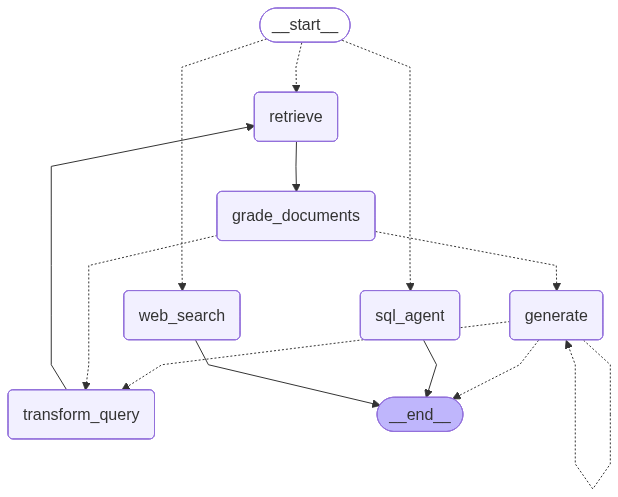

In [18]:
agent = create_adaptive_rag()
agent

In [19]:
config = {'configurable': {'thread_id': 'demo1'}}

query = "show me amazon's revenue in 2023?"
result = agent.invoke({'messages': [HumanMessage(query)]}, config=config)

[QUERY] show me amazon's revenue in 2023?
[DECISION] Routing to retrieve
[RETRIEVE] fetching documents...
[RETRIEVE] Query 1: show me amazon's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] show me amazon's revenue in 2023?
   [1] Doc 18: score=21.1139
   [2] Doc 7: score=20.5240
   [3] Doc 3: score=19.3040
[RETRIEVED] 3 documents
[GRADE] Evaluating document relevance
[GRADE] Relevance:  yes
[ROUTER] Assess graded documents
[ROUTER] Have relevant documents - generating answer
[GENERATE] Creating Answer
[ROUTER] Generation is gounded in documents
[ROUTER] Checking answer quality
[ROUTER] generation is good. - USEFUL


In [23]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

## Amazon's Revenue in 2023

Amazon's total **net sales (revenue)** for the fiscal year ended December 31, 2023, amounted to **$574.785 billion** [3]. This represents a **12% year-over-year increase** compared to 2022, when net sales were $513.983 billion [3]. 

### Breakdown by Business Segment
Amazon's revenue is divided across three segments:
- **North America**: $352.828 billion (61% of total revenue) [3]
- **International**: $131.200 billion (23% of total revenue) [3]
- **AWS**: $90.757 billion (16% of total revenue) [3]

### Key Drivers of Growth
- **North America** saw a 12% growth, driven by increased unit sales from third-party sellers, advertising, and subscription services [3].
- **International** revenue rose 11%, aided by similar factors, with foreign exchange rates adding $88 million to net sales in 2023 [3].
- **AWS** grew by 13%, contributing significantly to overall expansion [3].

### Cu

In [25]:
result = agent.invoke({'messages': [HumanMessage("What is the latest AI news?")]}, config=config)
print(result['messages'][-1].content)

[QUERY] What is the latest AI news?
[DECISION] Routing to web_search
[WEB] Agent is completed!
## Latest AI News Overview

The latest AI news as of 2023 is not explicitly detailed in the search results, which primarily list general news outlets. However, here are key insights and recommendations:

### **Key AI Developments (General Trends)**
- **AI Advancements**: Major tech companies continue to release cutting-edge models (e.g., Google's Gemini, Meta's Llama 3) and applications in healthcare, climate, and automation.
- **Ethics & Regulation**: Global discussions on AI governance, bias mitigation, and regulatory frameworks (e.g., EU AI Act) remain prominent.
- **Industry Adoption**: AI integration in sectors like finance, retail, and education accelerates, with tools like generative AI reshaping workflows.

### **Recommended Sources for AI News**
- **Specialized Outlets**: Follow AI-focused platforms like *MIT Technology Review*, *TechCrunch*, or *The Verge* for in-depth coverage.
- *

In [26]:
result = agent.invoke({'messages': [HumanMessage("How many employees are there?")]}, config=config)
print(result['messages'][-1].content)

[QUERY] How many employees are there?
[DECISION] Routing to sql_agent
[TOOL] Generated SQL Query: SELECT COUNT(*) AS total_emplo...
[TOOL] Your sql query is validated. Passed!
[SQL] Agent completed!
There are **300,024 employees** in the database.

This was determined by counting all records in the `employees` table, as it contains a list of all employees with `emp_no` as the primary key.


In [27]:
result = agent.invoke({'messages': [HumanMessage("show me average salary department wise")]}, config=config)
print(result['messages'][-1].content)

[QUERY] show me average salary department wise
[DECISION] Routing to sql_agent
[TOOL] Generated SQL Query: SELECT d.dept_name,
       AVG...
[TOOL] Your sql query is validated. Passed!
[SQL] Agent completed!
Here is the average salary by department, sorted from highest to lowest:

| Department         | Average Salary |
|--------------------|----------------|
| Sales              | $81,128.72     |
| Marketing         | $72,406.43     |
| Finance           | $70,899.76     |
| Research          | $60,182.94     |
| Production        | $60,086.69     |
| Development       | $59,957.12     |
| Customer Service  | $59,567.38     |
| Quality Management| $57,759.23     |
| Human Resources   | $56,181.15     |

The query successfully joined the `departments`, `dept_emp`, and `salaries` tables to calculate average salaries for active employees (those with `to_date = '9999-01-01'`). Let me know if you'd like to add more details or filter further!
